<div class="alert alert-success">
    <h1 align="center">Image reconstruction</h1>
    <h1 align="center">Using the Poutyne framework</h1>
    <h3 align="center"><a href="https://poutyne.org/"> Click on this tab for more information</a></h3>
</div>


In this example, we train a simple convolutional autoencoder (Conv-AE) on MNIST dataset to learn image reconstruction. The Conv-AE is composed of two parts: an encoder and a decoder. The encoder encodes the input images to extract compact image features. The extracted feature (here feature map, as all layers are convolutional) goes through the decoder to reconstruct the input image.

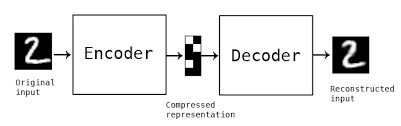

In [ ]:
pip install poutyne

In [ ]:
#importing the needed libraries

%matplotlib inline
%reload_ext autoreload
%autoreload 2

import numpy as np
import math
import os
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,Subset, Dataset


import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as tfms
from torchvision.utils import make_grid


import poutyne
from poutyne import set_seeds, Model, Experiment, ModelCheckpoint,CSVLogger



In [ ]:
# hyper parameters

num_epochs = 5
learning_rate = 0.001
batch_size = 32
image_size = 224
val_split_percent = 0.2
momentum = 0.5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print ('The running processor is...', device)
set_seeds(42)

The running processor is... cuda


The MNIST dataset is directly donlowded from torchvision.datasets. The training dataset contains 60,000 images of digits at the size of 28x28, However we seperate 20% of the full train dataset as validation dataset. On the other hand by passing "train" argument as False, the test dataset, containing 10,000 images is downloaded and saved in the dataset directory.

In [ ]:
# This section produces the original MNIST dataset, which is provided for classification applications. ---> (image, lable)
# In the next section we should redefine our datasets to make it proper for the reconstruction application. ---> (image, image)


if not os.path.exists('dataset'): os.mkdir('dataset')   # making a directory to download and save the datasets

full_train_dataset = datasets.MNIST('./dataset/', train=True, download=True, transform=tfms.ToTensor())
test_dataset = datasets.MNIST('./dataset/', train=False, download=True, transform=tfms.ToTensor())

# Selecting and seperating rate% (for example 20%) of the full train dataset for as validation dataset
indices = list(np.arange(len(full_train_dataset)))
np.random.shuffle(indices)
trn_indices = indices[math.floor(len(full_train_dataset)*val_split_percent):]
val_indices = indices[:math.floor(len(full_train_dataset)*val_split_percent)]


trn_dataset = Subset(full_train_dataset, trn_indices)
val_dataset = Subset(full_train_dataset, val_indices)

The original downloaded MNIST dataset, is provided fin classification application format, which means each sample is compsed of an image and the lable (eual to the number which that images shows). However, for image classification the dataset should contain an input image and a target image, which simply are the same. Hense, by the code below, we define a new dataset, which provides an image as an input and sets that image as its target as well.

In [ ]:
#This function changes the original MNIST dataset (originally proper for classification, as it contains labels) 
#to a dataset proper for image reconstruction.
#which changes the pair of (image,label) to a (image, image).

class mydataset(Dataset):       
        
    
        def __init__(self, dataset):
            self.dataset = dataset
            
        
        def __getitem__(self, index):
            
            input_image = self.dataset[index][0]
            reconstructed_image = input_image  # in image reconstruction input and traget images are the same
            
            return input_image, reconstructed_image
        def __len__(self):
            
            return len(self.dataset)   


In [ ]:
# producing the proper datasets and dataloaders for image reconstruction application, using the "mydataset" function.
trn_dataset_new = mydataset(trn_dataset)
val_dataset_new = mydataset(val_dataset)
test_dataset_new = mydataset(test_dataset)

trn_dataloader = DataLoader(trn_dataset_new, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset_new, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset_new, batch_size=1, shuffle=False)

In [ ]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        
        #encoder
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)  
        self.conv2 = nn.Conv2d(32, 4, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        #decoder
        self.t_conv1 = nn.ConvTranspose2d(4, 32, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(32, 1, 2, stride=2)

    def forward(self, x):
        
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)  # compressed representation
        
        x = torch.relu(self.t_conv1(x))
        x = torch.sigmoid(self.t_conv2(x))
                
        return x


network = ConvAutoencoder()
print(network)

ConvAutoencoder(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 32, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(32, 1, kernel_size=(2, 2), stride=(2, 2))
)


In order to interact with the optimization process, call backs are defined and saved in codes below, which saves the lastweights, best weights and the logs in row.

In [ ]:
#callbacks

save_path = 'saves'

# Creating saving directory 
os.makedirs(save_path, exist_ok=True)

callbacks = [
# Save the latest weights to be able to continue the optimization at the end for more epochs.
ModelCheckpoint(os.path.join(save_path, 'last_weights.ckpt')),

# Save the weights in a new file when the current model is better than all previous models.
ModelCheckpoint(os.path.join(save_path, 'best_weight.ckpt'),
                save_best_only=True, restore_best=True, verbose=True),

# Save the losses for each epoch in a TSV.
CSVLogger(os.path.join(save_path, 'log.tsv'), separator='\t'),
]

In [ ]:
# specifying loss and optimization function

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)

In [ ]:
# Poutyne Model on GPU
model = Model(network, optimizer, criterion, device=device)

# Train
model.fit_generator(trn_dataloader, val_dataloader, epochs=num_epochs, callbacks=callbacks, progress_options={'coloring': False})

Epoch: 1/5 Step: 1500/1500 100.00% |████████████████████|22.35s loss: 0.042889 val_loss: 0.029158
Epoch 1: val_loss improved from inf to 0.02916, saving file to saves/best_weight.ckpt
Epoch: 2/5 Step: 1500/1500 100.00% |████████████████████|22.10s loss: 0.026634 val_loss: 0.023818
Epoch 2: val_loss improved from 0.02916 to 0.02382, saving file to saves/best_weight.ckpt
Epoch: 3/5 Step: 1500/1500 100.00% |████████████████████|22.99s loss: 0.022496 val_loss: 0.021518
Epoch 3: val_loss improved from 0.02382 to 0.02152, saving file to saves/best_weight.ckpt
Epoch: 4/5 Step: 1500/1500 100.00% |████████████████████|21.96s loss: 0.020868 val_loss: 0.020440
Epoch 4: val_loss improved from 0.02152 to 0.02044, saving file to saves/best_weight.ckpt
Epoch: 5/5 Step: 1500/1500 100.00% |████████████████████|21.83s loss: 0.020034 val_loss: 0.019797
Epoch 5: val_loss improved from 0.02044 to 0.01980, saving file to saves/best_weight.ckpt
Restoring model from saves/best_weight.ckpt


[{'epoch': 1,
  'loss': 0.042888817086815835,
  'time': 22.35295373400004,
  'val_loss': 0.029158337180813152},
 {'epoch': 2,
  'loss': 0.02663403686011831,
  'time': 22.10114606299976,
  'val_loss': 0.023817934319376944},
 {'epoch': 3,
  'loss': 0.02249614226445556,
  'time': 22.987112360000083,
  'val_loss': 0.02151769397656123},
 {'epoch': 4,
  'loss': 0.020868006257961192,
  'time': 21.95595156699983,
  'val_loss': 0.020440032189091045},
 {'epoch': 5,
  'loss': 0.02003355091251433,
  'time': 21.834973953999906,
  'val_loss': 0.019796804750959077}]

# a random batch of input samples

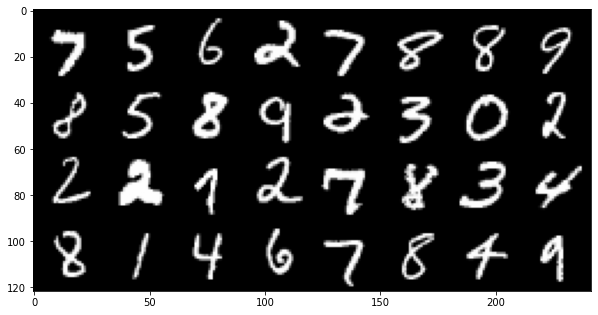

In [ ]:
inputs = next(iter(trn_dataloader))[0]
input_grid = make_grid(inputs)

fig = plt.figure(figsize=(10, 10))
inp = input_grid.numpy().transpose((1, 2, 0))
plt.imshow(inp)
plt.show()

# Reconstructed images after 4 epochs of training

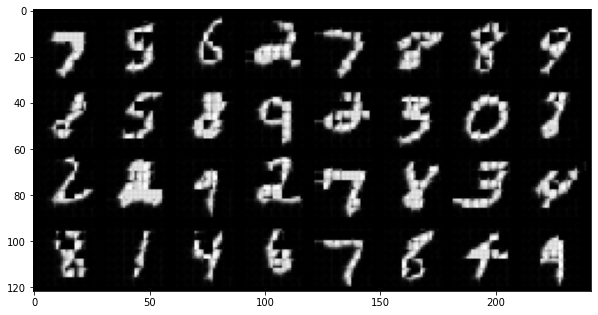

In [ ]:
# Calculating predictions of the trained network on a batch
outputs = torch.tensor(model.predict_on_batch(inputs))

output_grid = make_grid(outputs)
fig = plt.figure(figsize=(10, 10))
out = output_grid.numpy().transpose((1, 2, 0))
plt.imshow(out)
plt.show()

The code below show how we can takte advantages of poutyne to resume training from a special epoch (for example if we found the past epoch not enough, we can resume from the last done epoch, as below:

In [ ]:
model.fit_generator(trn_dataloader, val_dataloader, epochs=7, callbacks=callbacks, initial_epoch=num_epochs)

Epoch: 5/7 Step: 1500/1500 100.00% |████████████████████|22.13s loss: 0.019525 val_loss: 0.019379
Epoch 5: val_loss improved from 0.01980 to 0.01938, saving file to saves/best_weight.ckpt
Epoch: 6/7 Step: 1500/1500 100.00% |████████████████████|21.99s loss: 0.019125 val_loss: 0.019044
Epoch 6: val_loss improved from 0.01938 to 0.01904, saving file to saves/best_weight.ckpt
Epoch: 7/7 Step: 1500/1500 100.00% |████████████████████|21.24s loss: 0.018845 val_loss: 0.018818
Epoch 7: val_loss improved from 0.01904 to 0.01882, saving file to saves/best_weight.ckpt
Restoring model from saves/best_weight.ckpt


[{'epoch': 5,
  'loss': 0.019525130399813254,
  'time': 22.13099593600009,
  'val_loss': 0.01937860634426276},
 {'epoch': 6,
  'loss': 0.01912545581596593,
  'time': 21.99487811600011,
  'val_loss': 0.019044068900247416},
 {'epoch': 7,
  'loss': 0.018844680001338324,
  'time': 21.23843467100005,
  'val_loss': 0.018818224750459193}]

# Reconstructed images after the second training process

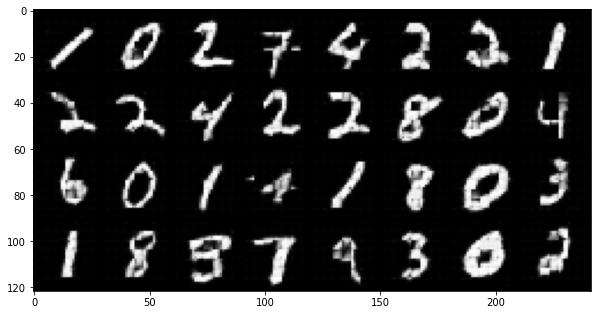

In [ ]:
outputs = torch.tensor(model.predict_on_batch(inputs))

output_grid = make_grid(outputs)
fig = plt.figure(figsize=(10, 10))
out = output_grid.numpy().transpose((1, 2, 0))
plt.imshow(out)
plt.show()

One of the strong and usefull tools in poutyne is the evaluate class, which not only provides you with the evaluation metrics, but also provides the Ground truth and the prediction, if related arguments has been set True (as below).

In [ ]:
# evaluating thetrained network on test data
loss, predictions, ground_truth = model.evaluate_generator(test_dataloader, return_pred=True, return_ground_truth=True)

In most of the computer vision applications, such as image reconstruction, it is very important to check the networks failures (or abilities, vice versa). The following part shows the input and the recontructed images, as well as the reconstruction error map. Reconstruction error map show which part of the image has not been reconstructed accuratelly.

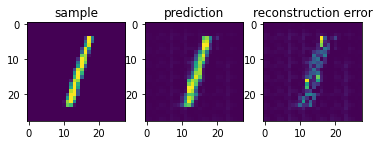

In [ ]:
sample_number = 2   # a sample from test dataset

sample = ground_truth[sample_number][0]
sample_prediction_result = predictions[sample_number][0]

recunstruction_error_map = sample - sample_prediction_result  #reconstruction error map
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.imshow(sample)
ax1.set_title('sample')


ax2.imshow(sample_prediction_result)
ax2.set_title('prediction')


ax3.imshow(np.abs(recunstruction_error_map))
ax3.set_title('reconstruction error')

plt.show()